<a href="https://colab.research.google.com/github/ACTP2002/EVIDENCE/blob/behavior_model/Behaviour_Model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --no-cache-dir -U numpy pandas scipy scikit-learn tensorflow shap matplotlib joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 174.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 170.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 166.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 140.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Suc

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation
import random

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import shap
import joblib


In [3]:
data_path = "synthetic_data_2026-02-07.csv"

df = pd.read_csv(data_path)
df.head()

,user_id,event_time,event_type,amount,currency,channel,declared_income,account_deposit,residence_country,transaction_country,amount_in_1d,amount_out_1d,login_count_1h,failed_login_1h,new_ip_1d,geo_change_1d
0,u_123,2025-04-29T00:41:35,deposit,4340.76,GBP,api,103233,201910,AU,AU,7383.39,7514.33,0,0,False,False
1,u_066,2025-12-12T02:40:46,withdrawal,7644.75,JPY,mobile,147944,491914,BR,BR,5619.80,13616.50,0,0,True,False
2,u_323,2025-03-03T11:31:43,sell,6430.32,USD,mobile,89130,57834,CN,CN,13932.37,3767.63,4,0,False,False
3,u_279,2025-11-24T00:26:14,buy,303.06,EUR,api,26802,421080,CN,CN,3947.08,1865.10,2,0,True,False
4,u_380,2025-04-22T23:01:29,buy,1164.22,EUR,api,25900,280156,MY,MY,1918.26,1456.34,0,0,False,False


In [4]:
# convert time to proper format
df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")
# sort by user id and event time
df = df.sort_values(["user_id", "event_time"]).reset_index(drop=True)

# Normalize categorical text to ensure all lower text
cat_cols_raw = [
    "currency", "channel",
    "residence_country", "transaction_country",
    "event_type"
]

for c in cat_cols_raw:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.lower()

In [5]:
df.head()

,user_id,event_time,event_type,amount,currency,channel,declared_income,account_deposit,residence_country,transaction_country,amount_in_1d,amount_out_1d,login_count_1h,failed_login_1h,new_ip_1d,geo_change_1d
0,u_000,2025-01-06 11:18:48,deposit,10254.28,gbp,mobile,102892,82668,vn,vn,12593.03,11280.03,0,0,False,False
1,u_000,2025-02-03 17:39:16,withdrawal,3584.68,usd,web,102892,82668,vn,vn,11413.28,7055.52,3,1,True,False
2,u_000,2025-02-14 13:10:20,deposit,7219.40,gbp,api,102892,82668,vn,vn,14621.12,8020.41,3,2,True,False
3,u_000,2025-02-15 17:08:36,withdrawal,9331.13,gbp,api,102892,82668,vn,vn,9792.10,9161.38,0,0,True,False
4,u_000,2025-02-18 00:55:12,deposit,5060.26,usd,mobile,102892,82668,vn,vn,15287.90,9269.69,1,2,False,False


Feature Engineering Process




1.   Rolling behaviour for each user. Purpose: To compare the behaviour within the n
window

User transaction rate:


*   More than 7 transactions => USER MEDIAN + USER MAD
*   Between 2 to 6 transactions => USER MEDIAN + GLOBAL MAD
*   1 Transaction => COHORT MEDIAN + MAD

2.   Transaction timing
3.   Financial Patterns
4.   Location Abnormality

In [6]:
# Transaction Amount Features

df["amount_abs"] = df["amount"].abs()

df["amount_to_income_ratio"] = (df["amount_abs"] / (df["declared_income"] + 1e-9))

df["deposit_to_income_ratio"] = (df["account_deposit"] / (df["declared_income"] + 1e-9))

# Net flow per day
df["net_flow_1d"] = df["amount_in_1d"] - df["amount_out_1d"]

# Transaction Gap features

grp = df.groupby("user_id", sort=False)

# Previous timestamp per group
df["prev_event_time"] = grp["event_time"].shift(1)

# Gap between consecutive transactions (in seconds)
df["gap_seconds"] = (df["event_time"] - df["prev_event_time"]).dt.total_seconds()

# Fill first-transaction gaps
df["gap_seconds"] = df["gap_seconds"].fillna(df["gap_seconds"].median())

# Log-scaled time gap
df["gap_log"] = np.log1p(df["gap_seconds"])


# Inconsistent Location

df["is_cross_border"] = (df["residence_country"] != df["transaction_country"]).astype(int)


# Access risk
df["failed_login_ratio_1h"] = (df["failed_login_1h"] / (df["login_count_1h"] + 1e-9))

df["new_ip_1d"] = df["new_ip_1d"].fillna(0)

df["geo_change_1d"] = df["geo_change_1d"].fillna(0)



In [7]:
# 1 TRANSACTION ONLY

EPS = 1e-9

# GLOBAL MEDIAN & MAD
GLOBAL_MEDIAN = df["amount_abs"].median()
GLOBAL_MAD = median_abs_deviation(df["amount_abs"], scale="normal") + EPS

# COHORT MEDIAN + MAD
cohort_cols = ["currency", "transaction_country", "channel", "event_type"]
cohort_stats = (df.groupby(cohort_cols)["amount_abs"].agg(["median", lambda x: median_abs_deviation(x, scale="normal")]).reset_index())
cohort_stats.columns = cohort_cols + ["cohort_median", "cohort_mad"]
cohort_stats["cohort_mad"] += 1e-9

df = df.merge(cohort_stats, on=cohort_cols, how="left")

In [8]:
ROLL_WINDOW = 15
ROLL_MIN = 2 # minimum transactions for rolling window else treated as single transaction

# Rolling windows (15 transactions minimum, 2 transactions at least to compute)
df["user_median_15"] = grp["amount_abs"].transform(lambda s: s.rolling(ROLL_WINDOW, min_periods=ROLL_MIN).median())

# Rolling MAD
df["user_mad_15"] = grp["amount_abs"].transform(lambda s: s.rolling(ROLL_WINDOW, min_periods=ROLL_MIN).apply(lambda x: median_abs_deviation(x, scale="normal"), raw=False))

# Fallback logic [User level => Cohort level => Global level]
df["baseline_median"] = df["user_median_15"].fillna(df["cohort_median"]).fillna(GLOBAL_MEDIAN)
df["baseline_mad"] = df["user_mad_15"].fillna(df["cohort_mad"]).fillna(GLOBAL_MAD)

# Modified z-score
df["mod_z_score"] = 0.6745 * (df["amount_abs"] - df["baseline_median"]) / (df["baseline_mad"] + EPS)
df["mod_z_score_abs"] = df["mod_z_score"].abs()

In [9]:
### EWMA (Exponentially Weighted Moving Average)
df["ewma"] = grp["amount_abs"].transform(lambda s: s.ewm(span=8, adjust=False).mean())

df["ewma_resid"] = (df["amount_abs"] - df["ewma"]).abs()


In [10]:
# Global chronological split (80,20)
cutoff = df["event_time"].quantile(0.8)

train_df = df[df["event_time"] <= cutoff].copy()
test_df = df[df["event_time"] > cutoff].copy()

print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (16000, 35) Test: (4000, 35)


Isolation Forest Model

Features: Transaction amount, Modified z-score (transaction changes), EWMA (drift), Transaction timing gap, Amount to income ratio and inconsistent location

Role: Globally detect any anomalous events

In [11]:
num_features = [
    "amount_abs",
    "mod_z_score_abs",
    "ewma_resid",
    "gap_log",
    "deposit_to_income_ratio",
    "amount_to_income_ratio",
    "amount_in_1d",
    "amount_out_1d",
    "net_flow_1d",
    "login_count_1h",
    "failed_login_ratio_1h",
    "new_ip_1d",
    "geo_change_1d",
    "is_cross_border"
]
# isolation_forest_features = ["amount_abs", "mod_z_score_abs", "ewma_resid", "gap_log", "deposit_to_income_ratio", "amount_to_income_ratio", "amount_in_1d", "net_flow_1d", "is_cross_border"]

cat_features = [
    "currency",
    "channel",
    "event_type",
    "transaction_country"
]

# isolation_forest_features = [c for c in isolation_forest_features if c in df.columns]
num_features = [c for c in num_features if c in df.columns]
cat_features = [c for c in cat_features if c in df.columns]

In [14]:
preprocess = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", RobustScaler())
                ]
            ),
            num_features
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("oh", OneHotEncoder(
                        handle_unknown="ignore",
                        min_frequency=10
                    ))
                ]
            ),
            cat_features
        ),
    ],
    remainder="drop"
)

In [39]:
# !pip install h2o
import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator
h2o.init()

encoding = "one_hot_explicit"
eif = H2OExtendedIsolationForestEstimator(
    ntrees = 600,
    sample_size = 256,
    extension_level = len(cat_features)+len(num_features)-1,
    seed = 42,
    categorical_encoding = encoding
)

eif.train(x=cat_features+num_features, training_frame=h2o.H2OFrame(train_df))


# Calculate score
eif_result = eif.predict(h2o.H2OFrame(test_df))

# Number in [0, 1] explicitly defined in Equation (1) from Extended Isolation Forest paper
# or in paragraph '2 Isolation and Isolation Trees' of Isolation Forest paper
anomaly_score = eif_result["anomaly_score"]

# Average path length  of the point in Isolation Trees from root to the leaf
mean_length = eif_result["mean_length"]


# isoForest_model = IsolationForest(
#     n_estimators=600,
#     max_samples="auto",
#     contamination="auto",
#     random_state=42,
#     n_jobs=-1
# )

# iso_pipe = Pipeline(
#     steps=[
#         ("prep", preprocess),
#         ("model", isoForest_model)
#     ]
# )

# iso_pipe.fit(train_df)

# # Scoring
# test_df["iforest_score"] = iso_pipe.decision_function(test_df)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 mins 45 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,2 months and 17 days
H2O_cluster_name:,H2O_from_python_unknownUser_4jzblq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.105 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [46]:
# Convert the H2OFrame to a pandas DataFrame and extract the values as a Series/Array
test_df["iforest_score"] = anomaly_score.as_data_frame().iloc[:, 0].values
test_df["mean_length"] = mean_length.as_data_frame().iloc[:, 0].values

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [ ]:
num_imputer = SimpleImputer(strategy="median")
num_scaler = RobustScaler()

X_train_isolation_forest = num_scaler.fit_transform(num_imputer.fit_transform(train_df[isolation_forest_features]))

X_test_isolation_forest = num_scaler.transform(num_imputer.fit_transform(test_df[isolation_forest_features]))

isoForest_model = IsolationForest(
    n_estimators=600,
    max_samples="auto",
    contamination="auto",
    random_state=42,
    n_jobs=-1
)

isoForest_model.fit(X_train_isolation_forest)

test_df["iforest_score"] = -isoForest_model.decision_function(X_test_isolation_forest)

In [47]:
print(test_df["iforest_score"])

53       0.545435
54       0.520196
55       0.509427
56       0.487488
57       0.429495
           ...   
19995    0.362551
19996    0.359743
19997    0.355397
19998    0.352996
19999    0.385331
Name: iforest_score, Length: 4000, dtype: float64


In [17]:
lstm_autoencoder_features = ["amount_abs", "gap_log", "amount_to_income_ratio", "mod_z_score_abs", "ewma_resid", "is_cross_border"]

seq_scaler = StandardScaler()
seq_scaler.fit(train_df[lstm_autoencoder_features].fillna(0))

def make_sequences(data_in, window=20):
  X = []
  idx = []
  for _, g in data_in.groupby("user_id", sort=False):
    arr = seq_scaler.transform(g[lstm_autoencoder_features].fillna(0))
    if len(arr) < window:
      continue
    for i in range (window - 1, len(arr)):
      X.append(arr[i-window+1:i+1])
      idx.append(g.index[i])
  return np.array(X), idx


X_training_lstm, idx_training_lstm = make_sequences (train_df)
X_testing_lstm, idx_testing_lstm = make_sequences (test_df)

In [18]:
lstm_model = models.Sequential([
    layers.Input(shape=(20, len(lstm_autoencoder_features))),
    layers.LSTM(64),
    layers.RepeatVector(20),
    layers.LSTM(64, return_sequences=True),
    layers.TimeDistributed(layers.Dense(len(lstm_autoencoder_features)))
])

lstm_model.compile(optimizer="adam", loss="mse")

lstm_model.fit(
    X_training_lstm, X_training_lstm,
    epochs=40,
    batch_size=256,
    validation_split=0.1,
    callbacks=[callbacks.EarlyStopping(patience=6, restore_best_weights=True)],
    verbose=2
)

Epoch 1/40
30/30 - 11s - 363ms/step - loss: 0.9944 - val_loss: 0.8171
Epoch 2/40
30/30 - 3s - 110ms/step - loss: 0.9612 - val_loss: 0.7752
Epoch 3/40
30/30 - 3s - 110ms/step - loss: 0.9005 - val_loss: 0.7038
Epoch 4/40
30/30 - 5s - 178ms/step - loss: 0.8279 - val_loss: 0.6532
Epoch 5/40
30/30 - 8s - 273ms/step - loss: 0.7798 - val_loss: 0.6041
Epoch 6/40
30/30 - 6s - 213ms/step - loss: 0.7461 - val_loss: 0.5858
Epoch 7/40
30/30 - 3s - 110ms/step - loss: 0.7344 - val_loss: 0.6065
Epoch 8/40
30/30 - 3s - 108ms/step - loss: 0.7060 - val_loss: 0.5702
Epoch 9/40
30/30 - 4s - 142ms/step - loss: 0.6766 - val_loss: 0.5256
Epoch 10/40
30/30 - 4s - 119ms/step - loss: 0.6760 - val_loss: 0.5292
Epoch 11/40
30/30 - 3s - 109ms/step - loss: 0.6560 - val_loss: 0.5050
Epoch 12/40
30/30 - 7s - 230ms/step - loss: 0.5956 - val_loss: 0.4647
Epoch 13/40
30/30 - 3s - 111ms/step - loss: 0.5676 - val_loss: 0.4432
Epoch 14/40
30/30 - 3s - 110ms/step - loss: 0.5978 - val_loss: 0.4493
Epoch 15/40
30/30 - 7s - 218

In [19]:
y_pred_lstm = lstm_model.predict(X_testing_lstm, verbose=0)
err = np.mean((X_testing_lstm - y_pred_lstm) ** 2, axis=(1, 2))

test_df["lstm_score"] = np.nan
for i, idx in enumerate(idx_testing_lstm):
  test_df.at[idx, "lstm_score"] = err[i]

test_df["lstm_score"] = test_df["lstm_score"].fillna(test_df["lstm_score"].median())

In [20]:
print(test_df["lstm_score"])

53       0.20832
54       0.20832
55       0.20832
56       0.20832
57       0.20832
          ...   
19995    0.20832
19996    0.20832
19997    0.20832
19998    0.20832
19999    0.20832
Name: lstm_score, Length: 4000, dtype: float64


In [48]:
detector_cols = ["mod_z_score_abs", "ewma_resid", "iforest_score", "lstm_score"]

# Calculate score
eif_train_result = eif.predict(h2o.H2OFrame(train_df))

# Number in [0, 1] explicitly defined in Equation (1) from Extended Isolation Forest paper
# or in paragraph '2 Isolation and Isolation Trees' of Isolation Forest paper
anomaly_train_score = eif_train_result["anomaly_score"]

# Average path length  of the point in Isolation Trees from root to the leaf
mean_train_length = eif_train_result["mean_length"]

train_df["iforest_score"] = anomaly_train_score.as_data_frame().iloc[:, 0].values
train_df["mean_length"] = mean_train_length.as_data_frame().iloc[:, 0].values

# train_df["iforest_score"] = -iso_pipe.decision_function(train_df)

y_pred_training_lstm = lstm_model.predict(X_training_lstm, verbose=0)
train_err = np.mean((X_training_lstm - y_pred_training_lstm) ** 2, axis=(1, 2))

train_df["lstm_score"] = np.nan
for i, idx in enumerate(idx_training_lstm):
  train_df.at[idx, "lstm_score"] = train_err[i]

train_df["lstm_score"] = train_df["lstm_score"].fillna(train_df["lstm_score"].median())


scaler = MinMaxScaler()
scaler.fit(train_df[detector_cols].fillna(0))

test_df[[c + "_n" for c in detector_cols]] = scaler.transform(test_df[detector_cols].fillna(0))

weights = {
    "mod_z_score_abs": 0.3,
    "ewma_resid": 0.15,
    "iforest_score": 0.3,
    "lstm_score": 0.25
}

test_df["final_score"] = sum(weights[c] * test_df[c+"_n"] for c in weights)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [60]:
threshold = test_df["final_score"].quantile(0.95)
test_df["is_anomaly"] = (test_df["final_score"] >= threshold).astype(int)

In [61]:
# # # fit_transform on TRAIN
# # X_train = preprocess.fit_transform(train_df)

# # transform only on TEST (to prevent data leakage)
# # X_test_isolation_forest = preprocess.transform(test_df)

# all_feature_names = preprocess.get_feature_names_out()



# all_feature_names = num_features + cat_features
# print(all_feature_names)

# # 2. Convert the transformed NumPy array back into a DataFrame
# # X_test is the output from preprocessor.transform(test_df)
# X_test_final = pd.DataFrame(test_df, columns=all_feature_names)

# explainer = shap.TreeExplainer(isoForest_model)
# shap_values = explainer.shap_values(X_test_final)

# shap.summary_plot(shap_values, X_test_final)

# from h2o.estimators import H2OExtendedIsolationForestEstimator

train_h2o = h2o.H2OFrame(train_df)
for col in cat_features:
    train_h2o[col] = train_h2o[col].asfactor()

train_with_score = train_h2o.cbind(eif_train_result["anomaly_score"])
train_with_score.set_names(train_with_score.names[:-1] + ["anomaly_score"])


from h2o.estimators import H2OGradientBoostingEstimator

surrogate = H2OGradientBoostingEstimator(
    ntrees=300,
    max_depth=6,
    seed=42
)

surrogate.train(
    x=cat_features + num_features,
    y="anomaly_score",
    training_frame=train_with_score
)

shap_values = surrogate.predict_contributions(train_with_score)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
contributions progress: |████████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


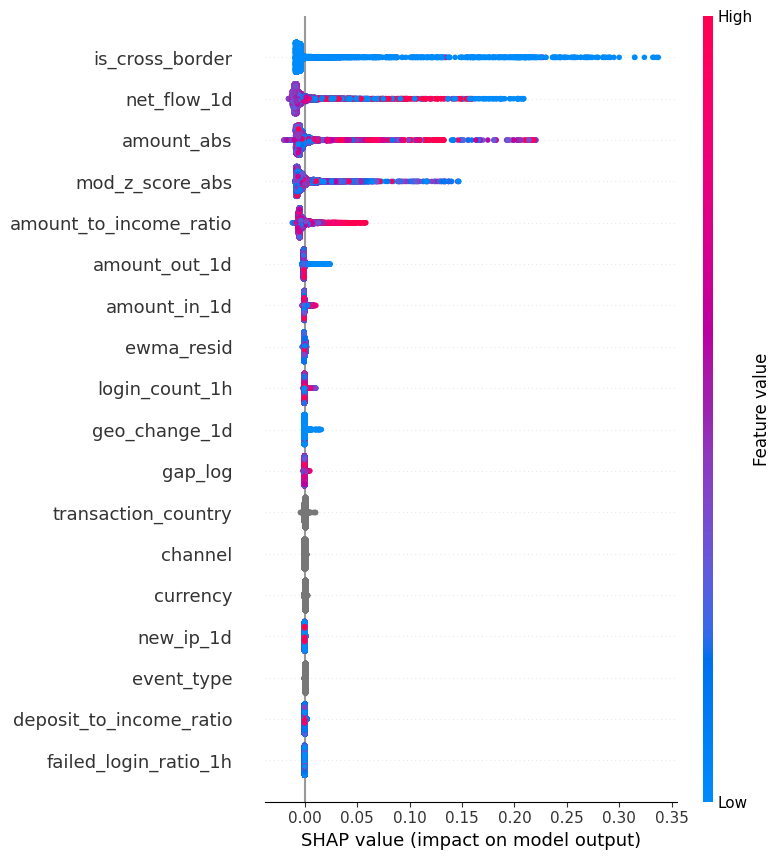

In [62]:
# Convert H2OFrame to pandas
shap_df = shap_values.as_data_frame()

# Remove bias term
shap_df = shap_df.drop(columns=["BiasTerm"])

# Feature matrix (must match training features order)
X = train_df[cat_features + num_features]

# Plot
shap.summary_plot(shap_df.values, X)


In [63]:
feature_err = np.mean((X_testing_lstm - y_pred_lstm) ** 2, axis=1)
feat_err_df = pd.DataFrame(feature_err, columns=lstm_autoencoder_features, index=idx_testing_lstm)

test_df["lstm_top_driver"] = feat_err_df.idxmax(axis=1)

In [64]:
print(test_df.tail())

      user_id          event_time  event_type   amount currency channel  \
19995   u_399 2025-11-17 21:17:33     deposit  4713.68      eur     api   
19996   u_399 2025-12-12 16:45:49        sell  7611.86      jpy     api   
19997   u_399 2025-12-17 07:19:54         buy  5856.27      usd  mobile   
19998   u_399 2025-12-30 00:06:50         buy  6626.92      jpy     api   
19999   u_399 2025-12-30 13:01:14  withdrawal  2309.51      usd     web   

       declared_income  account_deposit residence_country transaction_country  \
19995            83141           465409                cn                  cn   
19996            83141           465409                cn                  cn   
19997            83141           465409                cn                  cn   
19998            83141           465409                cn                  cn   
19999            83141           465409                cn                  cn   

       ...  iforest_score  lstm_score  mod_z_score_abs_n  ewma

Preprocessing Features
Isolation Forest handles numeric data only. We have both numeric and categorical data.

1. Column Transformer to apply preprocessing to each column type and **give one final numeric feature matric**

2. Numeric Pipeline


*   Simple Imputer - Fill missing values with median
*   Robust Scaler - scale features using median and IQR. Not standard scaler which is sensitive to outliers

3. Categorical Pipeline


*   Simple Imputer - Fill missing values with mode
*   One Hot Encoder - new categories are ignored and categories that appear less than 10 times grouped under one bucket (avoid rare categories as anomaly)

Other columns are dropped





In [ ]:
# Threshold
threshold = test_df["anomaly_score"].quantile(0.95)
test_df["is_anomaly_pred"] = (
    test_df["anomaly_score"] >= threshold
).astype(int)

In [ ]:
cols_to_view = [
    "user_id", "event_time", "event_type",
    "amount", "declared_income",
    "failed_login_1h", "login_count_1h",
    "new_ip_1d", "geo_change_1d",
    "residence_country", "transaction_country",
    "anomaly_score"
]
cols_to_view = [c for c in cols_to_view if c in test_df.columns]

print(
    test_df.sort_values("anomaly_score", ascending=False)[cols_to_view].head(20)
)


      user_id          event_time event_type     amount  declared_income  \
3349    u_067 2025-12-21 16:42:34    deposit  375798.08           137371   
9312    u_186 2025-10-30 21:49:41    deposit  425676.11           114773   
4477    u_090 2025-11-23 08:26:06    deposit  348662.82           118214   
16796   u_335 2025-12-16 10:41:20    deposit  366201.98           124662   
11650   u_232 2025-11-23 09:06:51    deposit  276509.68            67236   
15466   u_309 2025-12-21 00:24:54    deposit  428657.31           133177   
1510    u_029 2025-11-23 03:29:10    deposit  637127.11           140541   
19263   u_385 2025-11-15 02:30:57    deposit  298680.74            73080   
7665    u_154 2025-11-30 05:46:23    deposit  229644.71           111300   
7573    u_152 2025-12-13 20:17:36    deposit  297667.92            85727   
19120   u_382 2025-12-19 15:49:55    deposit  236344.19            59206   
4474    u_090 2025-11-17 14:53:58    deposit  230572.92           118214   
9625    u_19

In [65]:
user_anom = (
    test_df.groupby("user_id")["is_anomaly"]
    .sum()
    .sort_values(ascending=False)
)

print("Top 10 users by anomaly count:")
print(user_anom.head(10))


Top 10 users by anomaly count:
user_id
u_090    11
u_029    10
u_186     8
u_182     6
u_313     6
u_385     6
u_192     5
u_154     5
u_157     5
u_152     5
Name: is_anomaly, dtype: int64


In [66]:
n_users = user_anom.shape[0]
top_k = max(1, int(0.05 * n_users))

share_top5 = user_anom.head(top_k).sum() / (user_anom.sum() + 1e-9)

print(f"Top 5% users contribute: {share_top5:.2%} of all anomalies")


Top 5% users contribute: 50.00% of all anomalies


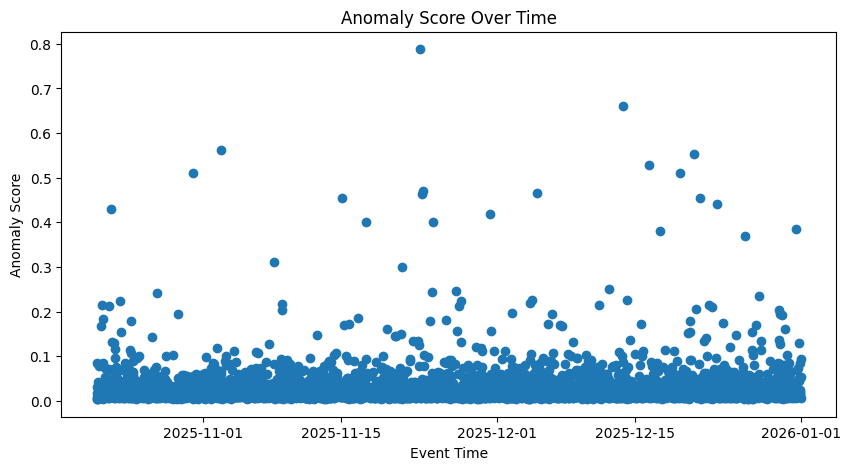

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(
    test_df["event_time"],
    test_df["final_score"]
)
plt.xlabel("Event Time")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Score Over Time")
plt.show()
